In [1]:
# useful to autoreload the module without restarting the kernel
%load_ext autoreload
%autoreload 2

In [38]:
from mppi import InputFiles as I, Calculators as C, Datasets as D, Utilities as U, Parsers as P
import matplotlib.pyplot as plt
import numpy as np
import os
from scipy.signal import argrelextrema

In [3]:
omp = 1
mpi = 4

# RT analysis of GaAs

This notebook contains the RT analysis of the photon echo mechanism for GaAs performed with Yambo.

## Single $k$ analysis

We perform various calculation with a single $k$ point to understand some aspects of the dynamics
of the polarization. In particular the topics to be addressed are, among the others:
* Decay time at single k, determination of the value of $\eta$ in term of the lenght of the simulation
* Circular vs linear polarization of the pump, are there some difference for the dynamics of the polarization?
* Identify the componenents of the polarizaion that are activated (both with or without the -nosym option)
* Study the frequency of oscillation of the polarization both during and after the pump. Seek for pump intensity 
    dependence of the frequency 

We build of the dictionary with the parameters of the various simulations

In [114]:
simulations = {
    'gamma_circ': {
        'source_dir' : 'NSCF/bnds_8-sampling_gamma.save',
        'run_dir' : 'RT_Gamma_circ', 
        'field_int' : 1000.0,
        'field_eng' : 1.42,
        'field_pol' : 'circular',
        'eta'       : 1e-4,
        'no_sym'    : False
    },
    'gamma_circ_f1e5': {
        'source_dir' : 'NSCF/bnds_8-sampling_gamma.save',
        'run_dir' : 'RT_Gamma_circ', 
        'field_int' : 1e5,
        'field_eng' : 1.42,
        'field_pol' : 'circular',
        'eta'       : 1e-4,
        'no_sym'    : False
    },
    'gamma_circ_f1e6': {
        'source_dir' : 'NSCF/bnds_8-sampling_gamma.save',
        'run_dir' : 'RT_Gamma_circ', 
        'field_int' : 1e6,
        'field_eng' : 1.42,
        'field_pol' : 'circular',
        'eta'       : 1e-4,
        'no_sym'    : False
    },
    'gamma_circ_f5e6': {
        'source_dir' : 'NSCF/bnds_8-sampling_gamma.save',
        'run_dir' : 'RT_Gamma_circ', 
        'field_int' : 5e6,
        'field_eng' : 1.42,
        'field_pol' : 'circular',
        'eta'       : 1e-4,
        'no_sym'    : False
    },
    'gamma_circ_shift': {
        'source_dir' : 'NSCF/bnds_8-sampling_gamma.save',
        'run_dir' : 'RT_Gamma_circ', 
        'field_int' : 1000.0,
        'field_eng' : 1.48,
        'field_pol' : 'circular',
        'eta'       : 1e-4,
        'no_sym'    : False
    },
    'gamma_circ_shift_f1e4': {
        'source_dir' : 'NSCF/bnds_8-sampling_gamma.save',
        'run_dir' : 'RT_Gamma_circ', 
        'field_int' : 1e4,
        'field_eng' : 1.48,
        'field_pol' : 'circular',
        'eta'       : 1e-4,
        'no_sym'    : False
    },
    'gamma_lin': {
        'source_dir' : 'NSCF/bnds_8-sampling_gamma.save',
        'run_dir' : 'RT_Gamma_lin', 
        'field_int' : 1000.0,
        'field_eng' : 1.42,
        'field_pol' : 'linear',
        'eta'       : 1e-4,
        'no_sym'    : False
    },
    'gamma_circ_nosym': {
        'source_dir' : 'NSCF/bnds_8-sampling_gamma.save',
        'run_dir' : 'RT_Gamma_nosym', 
        'field_int' : 1000.0,
        'field_eng' : 1.42,
        'field_pol' : 'circular',
        'eta'       : 1e-4,
        'no_sym'    : True
    }
}

We add the rt_run_dir key

In [115]:
for pars in simulations.values():
    if pars['no_sym'] is False: 
        pars['rt_run_dir'] = os.path.join(pars['run_dir'],'FixSymm')
    if pars['no_sym'] is True: 
        pars['rt_run_dir'] = pars['run_dir']

In [116]:
#simulations

### Construction of the SAVE folder and FixSymm procedure

We build the SAVE folder, the FixSymm procedure is performed if needed

In [7]:
for sim,pars in simulations.items():
    source_dir = pars['source_dir']
    run_dir = pars['run_dir']
    rt_run_dir = pars['rt_run_dir']
    if not pars['no_sym']:
        print('build SAVE and perform FixSymm for %s'%sim)
        U.build_SAVE(source_dir,run_dir,make_link=True)
        fixSymm_inp = I.YamboInput('ypp -y',folder=run_dir)
        fixSymm_inp.removeTimeReversal()
        if pars['field_pol'] == 'circular':
            fixSymm_inp.set_ypp_extFields(Efield1=[1.,0.,0.],Efield2=[0.,1.,0.])
        if pars['field_pol'] == 'linear':
            fixSymm_inp.set_ypp_extFields(Efield1=[1.,0.,0.])
        code = C.YamboCalculator(mpi=1,executable='ypp')
        code.run(inputs=[fixSymm_inp],names=['FixSymm'],run_dir=run_dir)
        command = 'cd %s; yambo_rt'%rt_run_dir
        print(command)
        os.system(command)
    else:
        print('build SAVE for %s sim with the -nosym option'%sim)
        U.build_SAVE(source_dir,run_dir,make_link=True,command='p2y -nosym')
    print(' ')

build SAVE and perform FixSymm for gamma_circ
Create folder RT_Gamma_circ
Executing command: cd NSCF/bnds_8-sampling_gamma.save; p2y -a 2
Create a symlink of /home/marco/Data/RICERCA/DFT AND MANY BODY/OPTICAL ORIENTATION/Echo mechanisms and decay time/PHOTON_ECO/NSCF/bnds_8-sampling_gamma.save/SAVE in RT_Gamma_circ
Executing command: cd RT_Gamma_circ;OMP_NUM_THREADS=1 yambo
Initialize a parallel Yambo calculator with scheduler direct
run 0 command: cd RT_Gamma_circ; mpirun -np 1 ypp -F FixSymm.in -J FixSymm -C FixSymm
run0_is_running: True 
Job completed
cd RT_Gamma_circ/FixSymm; yambo_rt
 
build SAVE and perform FixSymm for gamma_lin
Create folder RT_Gamma_lin
Executing command: cd NSCF/bnds_8-sampling_gamma.save; p2y -a 2
Create a symlink of /home/marco/Data/RICERCA/DFT AND MANY BODY/OPTICAL ORIENTATION/Echo mechanisms and decay time/PHOTON_ECO/NSCF/bnds_8-sampling_gamma.save/SAVE in RT_Gamma_lin
Executing command: cd RT_Gamma_lin;OMP_NUM_THREADS=1 yambo
Initialize a parallel Yambo c

In [8]:
#simulations

Remove the contribution of the pseudo from the commutator

In [9]:
for pars in simulations.values():
    rt_run_dir = pars['rt_run_dir']
    db = 'ns.kb_pp_pwscf'
    src = os.path.join(rt_run_dir,'SAVE',db)
    dst = os.path.join(rt_run_dir,'SAVE',db+'_hide')
    command = 'mv %s %s'%(src,dst)
    print(command)
    os.system(command)

mv RT_Gamma_circ/FixSymm/SAVE/ns.kb_pp_pwscf RT_Gamma_circ/FixSymm/SAVE/ns.kb_pp_pwscf_hide
mv RT_Gamma_lin/FixSymm/SAVE/ns.kb_pp_pwscf RT_Gamma_lin/FixSymm/SAVE/ns.kb_pp_pwscf_hide
mv RT_Gamma_nosym/SAVE/ns.kb_pp_pwscf RT_Gamma_nosym/SAVE/ns.kb_pp_pwscf_hide


### Running of the simulations

We build the input object for each simulation. Some parameters are common for all the simulations
and are specified here, the others are taken from the dictionary

In [117]:
# Common parameters

field_width = 100 #fs set the width of the FWHM 
bands = [3,5] # include the three valence bands (2-4) and the first conduction band (5)
scissor = 0.9548 # (eV) (taken from QE_Analysis it gives a direct gap of 1.42 eV)
time_step = 10 # as
sim_time = 1000 # fs

In [118]:
for pars in simulations.values():
    rt_input = I.YamboInput('yambo_rt -n p -v ip -V rt',folder=pars['rt_run_dir'])
    rt_input.set_rt_field(int=pars['field_int'],width=field_width,polarization=pars['field_pol'],freq=pars['field_eng'])
    rt_input.set_rt_bands(bands=bands,scissor=scissor,damping_valence=pars['eta'],damping_conduction=pars['eta'])
    rt_input.set_rt_simulationTimes(sim_time=sim_time,time_units='fs',time_step=time_step)
    rt_input.set_rt_cpu(mpi)
    rt_input['variables']['DBsIOoff']='obs'  # do not write ndb.RT_observables on disk
    rt_input['variables']['IOtime'] = [[1.0,5.0,0.1],'fs']
    pars['input'] = rt_input

Since the simulations have different run_dir we do not create a dataset but we directly use the run method of the 
calculator(s). 

The parsing of the results for each computation is added as a key in the simulations dictionary.

In [119]:
code = C.YamboCalculator(omp=omp,mpi=mpi,executable='yambo_rt',IO_time=10)

for sim in simulations.values():
    idd = dict((k,sim[k]) for k in ['field_int','field_eng','eta'])
    name = D.name_from_id(idd)
    results = code.run(inputs=[sim['input']],names=[name],run_dir=sim['rt_run_dir'])
    sim['results'] = P.YamboParser(results['output'][0])

Initialize a parallel Yambo calculator with scheduler direct
Skip the run of eta_0.0001-field_eng_1.42-field_int_1000.0
Job completed
Skip the run of eta_0.0001-field_eng_1.42-field_int_100000.0
Job completed
Skip the run of eta_0.0001-field_eng_1.42-field_int_1000000.0
Job completed
run 0 command: cd RT_Gamma_circ/FixSymm; mpirun -np 4 yambo_rt -F eta_0.0001-field_eng_1.42-field_int_5000000.0.in -J eta_0.0001-field_eng_1.42-field_int_5000000.0 -C eta_0.0001-field_eng_1.42-field_int_5000000.0
run0_is_running: True 
run0_is_running: True 
run0_is_running: True 
Job completed
Skip the run of eta_0.0001-field_eng_1.48-field_int_1000.0
Job completed
Skip the run of eta_0.0001-field_eng_1.48-field_int_10000.0
Job completed
Skip the run of eta_0.0001-field_eng_1.42-field_int_1000.0
Job completed
Skip the run of eta_0.0001-field_eng_1.42-field_int_1000.0
Job completed


We compare the various components of the polarization for the circular, linear and circular with nosym calculations

In [123]:
sel_sim = dict((k,simulations[k]) for k in ['gamma_circ','gamma_lin','gamma_circ_nosym'])

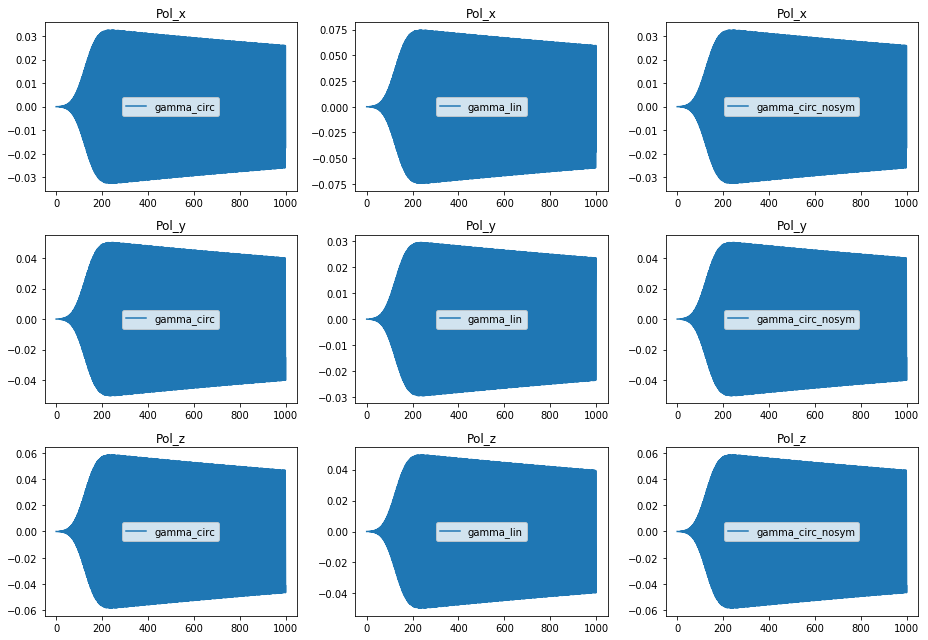

In [124]:
fig, axs = plt.subplots(3, 3,figsize=(13,9))
comps = ['Pol_x','Pol_y','Pol_z']
for ind_c,c in enumerate(comps):
    ind_s = 0
    for study,val in sel_sim.items():
        pol = val['results']['polarization']
        time = pol['time']
        p = pol[c]
        axs[ind_c,ind_s].plot(time,p,label=study)
        axs[ind_c,ind_s].set_title(c)
        axs[ind_c,ind_s].legend(loc='best')
        ind_s += 1
fig.tight_layout()

We compare the number of carriers in the various simulation

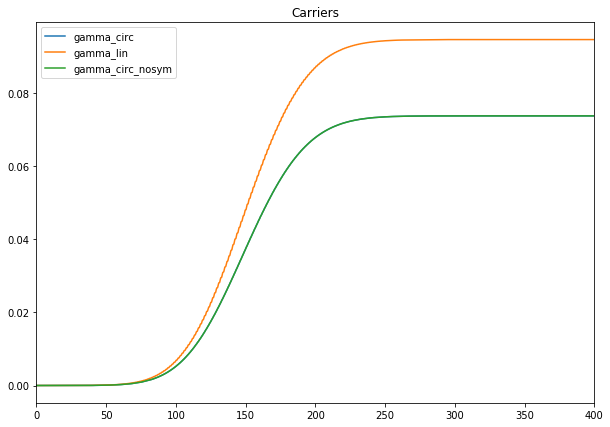

In [125]:
fig, ax = plt.subplots(figsize=(10, 7))
for study,val in sel_sim.items():
    carr = val['results']['carriers']
    time = carr['time']
    dne = carr['dne']
    ax.plot(time,dne,label=study)
    ax.set_xlim(0,400)
    ax.set_title('Carriers')
    ax.legend(loc='best')

Results with circular polarization are one on top of the other, while the one related to linear polarization is
a little bit higher. 

Let's see what happens with a very intense field (with no dephasing)

In [121]:
sel_sim = dict((k,simulations[k]) for k in ['gamma_circ_f1e5','gamma_circ_f1e6','gamma_circ_f5e6'])

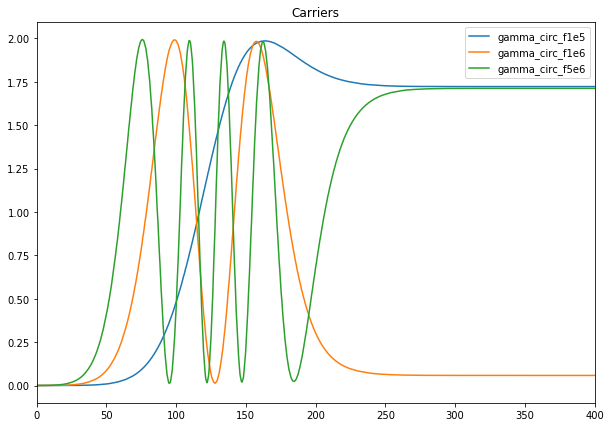

In [122]:
fig, ax = plt.subplots(figsize=(10, 7))
for study,val in sel_sim.items():
    carr = val['results']['carriers']
    time = carr['time']
    dne = carr['dne']
    ax.plot(time,dne,label=study)
    ax.set_xlim(0,400)
    ax.set_title('Carriers')
    ax.legend(loc='best')

We investigate on the frequency of the oscillations. We consider the $z$ components for the circular polarization
and compute the period of the oscillations in function of time in the various cases

In [73]:
sel_sim = dict((k,simulations[k]) for k in ['gamma_circ','gamma_circ_shift','gamma_circ_shift_f1e4'])

In [74]:
time = {}
pz = {}
t_max = {}
for study,vals in sel_sim.items():
    r = vals['results']['polarization']
    time[study] = r['time']
    pz[study] = r['Pol_z']
    t_max[study] = time[study][argrelextrema(pz[study], np.greater)[0]]

(-0.08765706465, 0.08757507345)

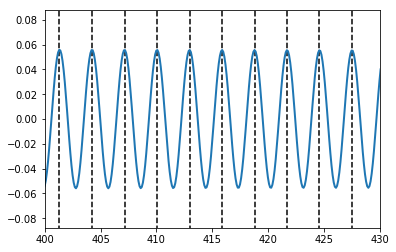

In [84]:
s = 'gamma_circ'
plt.plot(time[s],pz[s],linewidth=2)
plt.vlines(t_max[s],-1,1,linestyles='--')
plt.xlim(400,430)
plt.ylim(1.5*min(pz[s]),1.5*max(pz[s]))

We compute the energy associated to the period of oscillation

In [76]:
freq = {}
for study in sel_sim:
    delta = [1] # set arbitrary to one to avoid divergence 
    for ind in range(len(t_max[study])-1):
        delta.append(t_max[study][ind+1]-t_max[study][ind])
    delta = np.array(delta)
    freq[study] = U.Planck_ev_ps*1e3/delta # E = hv with h in eV*fs

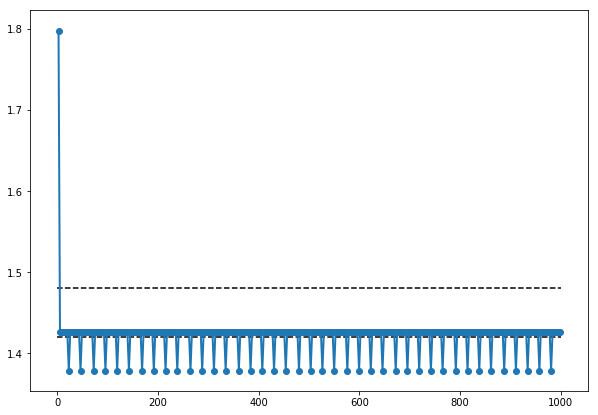

(400, 500)

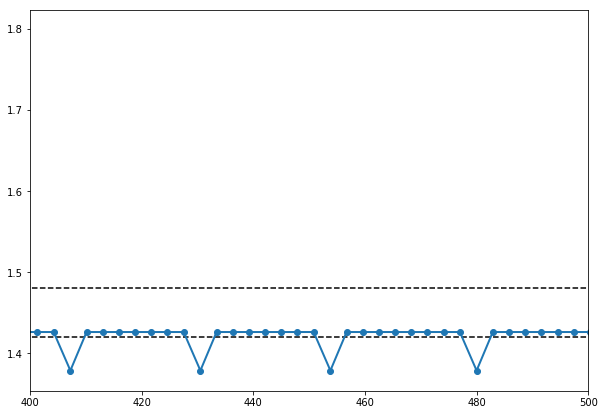

In [82]:
s = 'gamma_circ'

fig, ax = plt.subplots(figsize=(10, 7))
plt.plot(t_max[s][1:],freq[s][1:],linewidth=2)
plt.scatter(t_max[s][1:],freq[s][1:])
plt.hlines(1.42,0,1000,linestyles='--')
plt.hlines(1.48,0,1000,linestyles='--')
plt.show()

fig, ax = plt.subplots(figsize=(10, 7))
plt.plot(t_max[s][1:],freq[s][1:],linewidth=2)
plt.scatter(t_max[s][1:],freq[s][1:])
plt.hlines(1.42,0,1000,linestyles='--')
plt.hlines(1.48,0,1000,linestyles='--')
plt.xlim(400,500)

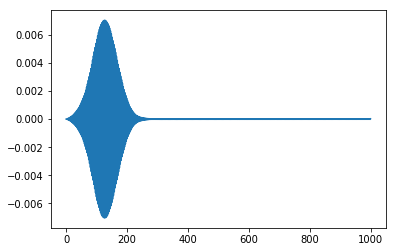

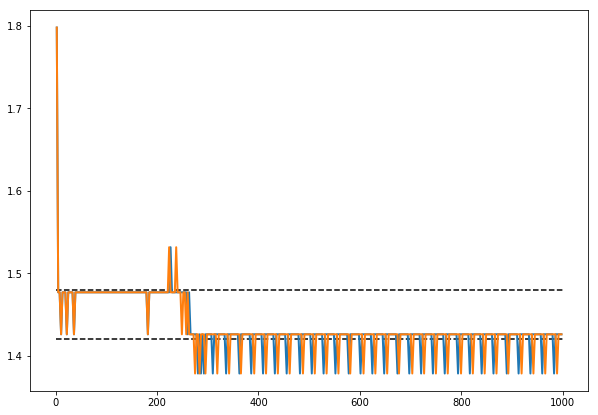

In [85]:
s1 = 'gamma_circ_shift'
s2 = 'gamma_circ_shift_f1e4'

plt.plot(time[s1],pz[s1])
plt.show()

fig, ax = plt.subplots(figsize=(10, 7))
plt.plot(t_max[s1][1:],freq[s1][1:],linewidth=2)
plt.plot(t_max[s2][1:],freq[s2][1:],linewidth=2)
plt.hlines(1.42,0,1000,linestyles='--')
plt.hlines(1.48,0,1000,linestyles='--')